In [207]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/01_source.wav')
(target_fs, target_data) = wavfile.read('./data/01_gr-jump-head-hg.wav')


In [208]:
import pandas as pd

In [209]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])
source_df.head()

L   R
0   1  -1
1  -5  -6
2 -11 -12
3 -18 -17
4 -24 -24

In [210]:
target_df = pd.DataFrame(target_data, columns=['L', 'R'])
target_df.head()

L  R
0  1  0
1  0  0
2  0  1
3  0  0
4  0  1

In [211]:
source_df['L'].max(), target_df['L'].max()

(10790, 24606)

In [212]:
2 ** 15

32768

In [213]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [214]:
len(source_df), len(target_df)

(1302647, 1302647)

In [215]:
# END_LOC = int(len(target_df) * 0.8)
TR_END_LOC = int(len(target_df) * 0.8 / 100) * 100
TR_END_LOC

1042100

## IT'S MONO

In [216]:
X_train_raw = source_df['L'][:TR_END_LOC]
len(X_train_raw)

1042100

In [217]:
X_test_raw = source_df['L'][TR_END_LOC:]
len(X_test_raw)

260547

In [218]:
y_train_raw = target_df['L'][:TR_END_LOC]
len(y_train_raw)

1042100

In [219]:
y_test_raw = target_df['L'][TR_END_LOC:]
len(y_test_raw)

260547

In [220]:
X_test_raw.iloc[:10]

1042100    3458
1042101    3469
1042102    3479
1042103    3485
1042104    3490
1042105    3491
1042106    3489
1042107    3485
1042108    3479
1042109    3471
Name: L, dtype: int16

In [221]:
# safe-checking data

In [222]:
# y_train_raw = -y_train_raw + 4000
# y_train_raw.iloc[0]

In [223]:
# y_test_raw = -y_test_raw + 4000
# y_test_raw.iloc[0]

## Preparing data for processing

In [224]:
def normalize_keeping_mean(arr, forced_abs=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
    
    return np.clip(arr / n, -1.0, 1.0)

In [225]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [226]:
import numpy as np

X_tr = np.array(list(map(lambda x: np.array(x), X_train_raw)))
X_tr_n = normalize(X_tr, forced_abs=MAX_VALUE, mean=0.0)
X_tr_n.min(), X_tr_n.max(), np.mean(X_tr_n)

(-0.30961027863399154, 0.3292947172460097, 5.524491569495269e-06)

In [227]:
X_te = np.array(list(map(lambda x: np.array(x), X_test_raw)))
X_te_n= normalize(X_te, forced_abs=MAX_VALUE, mean=0.0)
X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038026062807, 0.2346873378704184, 1.2222185906085745e-05)

In [228]:
y_tr = np.array(list(map(lambda x: np.array(x), y_train_raw)))
y_tr_n = normalize(y_tr, forced_abs=MAX_VALUE, mean=0.0)
y_tr_n.min(), y_tr_n.max(), np.mean(y_tr_n)

(-0.7998596148564104, 0.7509384441663869, 0.0374263444881614)

In [229]:
y_te = np.array(list(map(lambda x: np.array(x), y_test_raw)))
y_te_n = normalize(y_te, forced_abs=MAX_VALUE, mean=0.0)
y_te_n.min(), y_te_n.max(), np.mean(y_te_n)

(-0.7517319254127628, 0.7195654164250618, 0.022822304137312396)

In [230]:
X_tr_n = X_tr_n.astype('float32')
X_te_n = X_te_n.astype('float32')
y_tr_n = y_tr_n.astype('float32')
y_te_n = y_te_n.astype('float32')

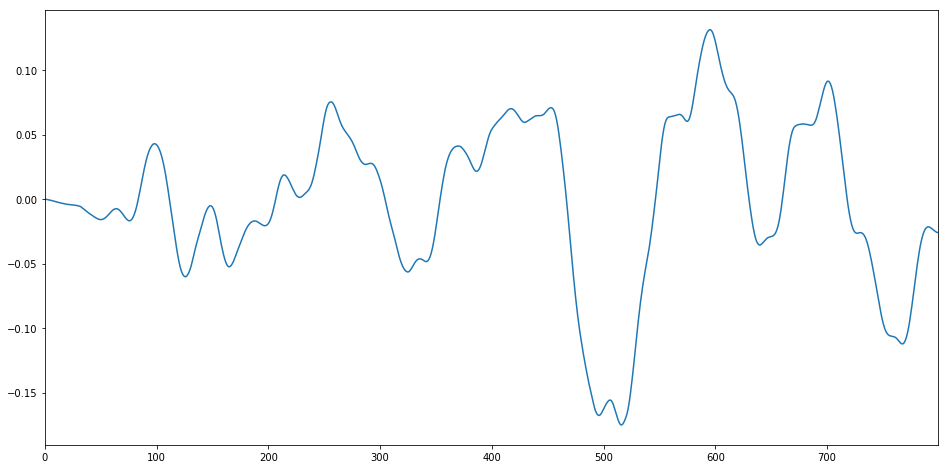

In [231]:
%matplotlib inline

pd.Series(X_tr_n[:800]).plot.line(figsize=(16, 8))

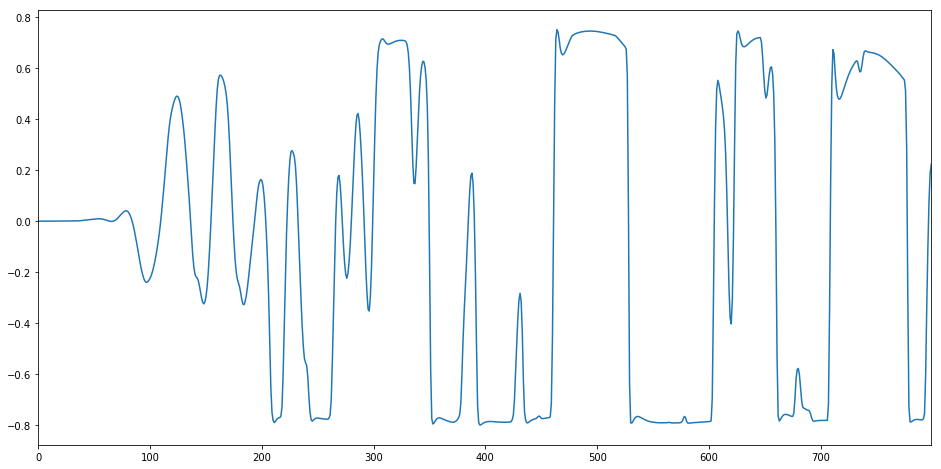

In [232]:
pd.Series(y_tr_n[:800]).plot.line(figsize=(16, 8))

In [233]:

X_te_n.min(), X_te_n.max(), np.mean(X_te_n)

(-0.1662038, 0.23468734, 1.2222178e-05)

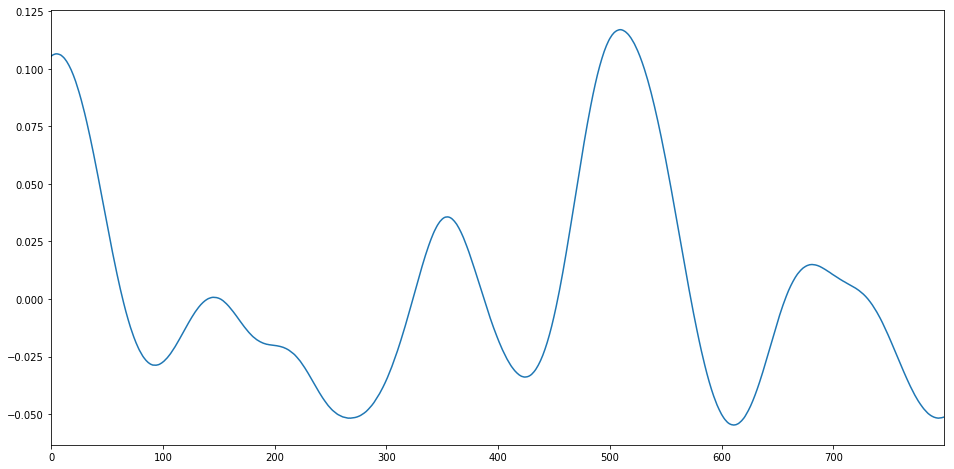

In [234]:
pd.Series(X_te_n[:800]).plot.line(figsize=(16, 8))

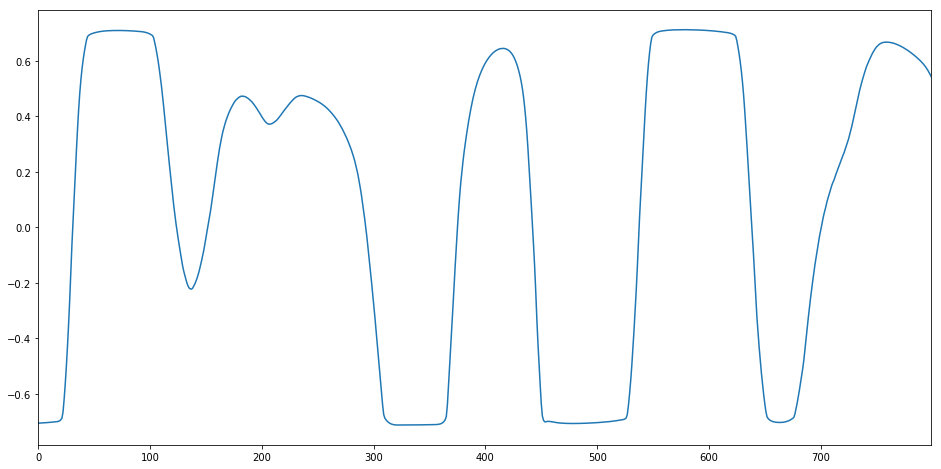

In [235]:
pd.Series(y_te_n[:800]).plot.line(figsize=(16, 8))

In [236]:
# appending stats of the whole sample, fading from silence

In [237]:
# train_shuffle_index = np.random.shuffle(np.arange(0, len(X_tr_n)))
# test_shuffle_index = np.random.shuffle(np.arange(0, len(X_te_n)))

# X_tr_f = X_tr_n[train_shuffle_index][0]
# y_tr_f = y_tr_n[train_shuffle_index][0]

# X_te_f = X_te_n[test_shuffle_index][0]
# y_te_f = y_te_n[test_shuffle_index][0]

## Making windows

In [238]:
# N_WINDOW_POINTS = int(source_clean_fs * 0.02)
N_WINDOW_POINTS = 64
N_WINDOW_POINTS

64

In [239]:
N_SAMPLES = 44000 * 12
N_SAMPLES

528000

In [240]:
def make_windows(X, y, n_window_points):
    X_index = X.index
    index = 0
    
    res_X = []
    res_y = []

    for index in range(0, len(X) - n_window_points - 1):
        res_X.append(X.iloc[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y.iloc[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [241]:
%%time
(X_tr_f, y_tr_f) = make_windows(
    pd.Series(X_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_tr_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS)
print((len(X_tr_f), X_tr_f[0], y_tr_f[0]))

globals().update(locals())

(528000, array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
       -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
       -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
       -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
       -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
       -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
       -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
       -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
       -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
       -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
       -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
       -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
       -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
       -1.559495

In [242]:
X_tr_f[1], y_tr_f[1]

(array([-0.00015259, -0.0003357 , -0.00054933, -0.00073244, -0.00091556,
        -0.00112918, -0.00140385, -0.00161748, -0.00186163, -0.00210578,
        -0.00238044, -0.00259407, -0.0028077 , -0.00302133, -0.00323496,
        -0.00338755, -0.00354015, -0.00375378, -0.00393689, -0.00408948,
        -0.00421155, -0.00430311, -0.00439467, -0.0044557 , -0.00457778,
        -0.00469985, -0.00479141, -0.004944  , -0.00506607, -0.00531022,
        -0.00552385, -0.00585955, -0.00650044, -0.00714133, -0.00787378,
        -0.00854518, -0.00927763, -0.00994903, -0.01068148, -0.01129185,
        -0.0118717 , -0.01248207, -0.01306192, -0.01367229, -0.01422163,
        -0.01474044, -0.01519822, -0.01559496, -0.01583911, -0.01593066,
        -0.01583911, -0.01559496, -0.01519822, -0.01461837, -0.01388592,
        -0.0130314 , -0.01211585, -0.01113926, -0.01019318, -0.00924711,
        -0.00851466, -0.00793481, -0.00759911, -0.00747703], dtype=float32),
 -0.0005798517)

In [243]:
%%time
(X_te_f, y_te_f) = make_windows(
    pd.Series(X_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    pd.Series(y_te_n[:(N_SAMPLES + N_WINDOW_POINTS + 1)]),
    N_WINDOW_POINTS
)
print((len(X_te_f), X_te_f[0], y_te_f[0]))

globals().update(locals())

(260482, array([0.105533  , 0.10586871, 0.1061739 , 0.10635701, 0.1065096 ,
       0.10654011, 0.10647908, 0.10635701, 0.1061739 , 0.10592975,
       0.105533  , 0.10507523, 0.10455641, 0.10391553, 0.1032136 ,
       0.10242012, 0.10153508, 0.10058901, 0.09955138, 0.09839167,
       0.09720145, 0.09588916, 0.09454634, 0.09305093, 0.09155553,
       0.08990753, 0.08822901, 0.08648945, 0.08465835, 0.0827662 ,
       0.08084353, 0.07882931, 0.07672353, 0.07458724, 0.07238991,
       0.07016205, 0.06787317, 0.06552324, 0.0631428 , 0.06073184,
       0.05829035, 0.05578784, 0.05328532, 0.0507828 , 0.04821924,
       0.04565569, 0.04306162, 0.04049806, 0.03790399, 0.03530991,
       0.03277688, 0.03021332, 0.02764977, 0.02517777, 0.02264473,
       0.02023377, 0.01782281, 0.01544237, 0.01312296, 0.01083407,
       0.00860622, 0.00640889, 0.00424207, 0.00219733], dtype=float32), 0.7086398)
CPU times: user 28.5 s, sys: 0 ns, total: 28.5 s
Wall time: 28.5 s


In [244]:
X_te_f[1], y_te_f[1]

(array([0.10586871, 0.1061739 , 0.10635701, 0.1065096 , 0.10654011,
        0.10647908, 0.10635701, 0.1061739 , 0.10592975, 0.105533  ,
        0.10507523, 0.10455641, 0.10391553, 0.1032136 , 0.10242012,
        0.10153508, 0.10058901, 0.09955138, 0.09839167, 0.09720145,
        0.09588916, 0.09454634, 0.09305093, 0.09155553, 0.08990753,
        0.08822901, 0.08648945, 0.08465835, 0.0827662 , 0.08084353,
        0.07882931, 0.07672353, 0.07458724, 0.07238991, 0.07016205,
        0.06787317, 0.06552324, 0.0631428 , 0.06073184, 0.05829035,
        0.05578784, 0.05328532, 0.0507828 , 0.04821924, 0.04565569,
        0.04306162, 0.04049806, 0.03790399, 0.03530991, 0.03277688,
        0.03021332, 0.02764977, 0.02517777, 0.02264473, 0.02023377,
        0.01782281, 0.01544237, 0.01312296, 0.01083407, 0.00860622,
        0.00640889, 0.00424207, 0.00219733, 0.00015259], dtype=float32),
 0.7088229)

In [245]:
# import numpy as np

# train_shuffle_index = np.arange(0, len(X_tr_f))
# np.random.shuffle(train_shuffle_index)

# test_shuffle_index = np.arange(0, len(X_te_f))
# np.random.shuffle(test_shuffle_index)

# X_tr_f = np.array(X_tr_f)[train_shuffle_index]
# y_tr_f = np.array(y_tr_f)[train_shuffle_index]

# X_te_f = np.array(X_te_f)[test_shuffle_index]
# y_te_f = np.array(y_te_f)[test_shuffle_index]

# X_tr_f[0], y_tr_f[0], len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f)

In [246]:
# X_tr_f = X_tr_n
# y_tr_f = y_tr_n

# X_te_f = X_te_n
# y_te_f = y_te_n

In [247]:
(len(X_tr_f), len(y_tr_f), len(X_te_f), len(y_te_f))

(528000, 528000, 260482, 260482)

In [248]:
# list(map(lambda row: row[:N_PEAKS*2], X_tr_f))[0]
# # list(map(lambda row: row[:N_PEAKS], X_tr_f))[0]

In [249]:
# from matplotlib import pyplot as plt

# # amp_df = pd.DataFrame(list(map(lambda row: row[N_PEAKS:N_PEAKS*2], X_tr_f)))
# amp_df = pd.DataFrame(list(map(lambda row: row, X_tr_f)))

# f = plt.figure(figsize=(19, 15))
# plt.matshow(amp_df.corr())
# plt.xticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14, rotation=45)
# plt.yticks(range(amp_df.shape[1]), amp_df.columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

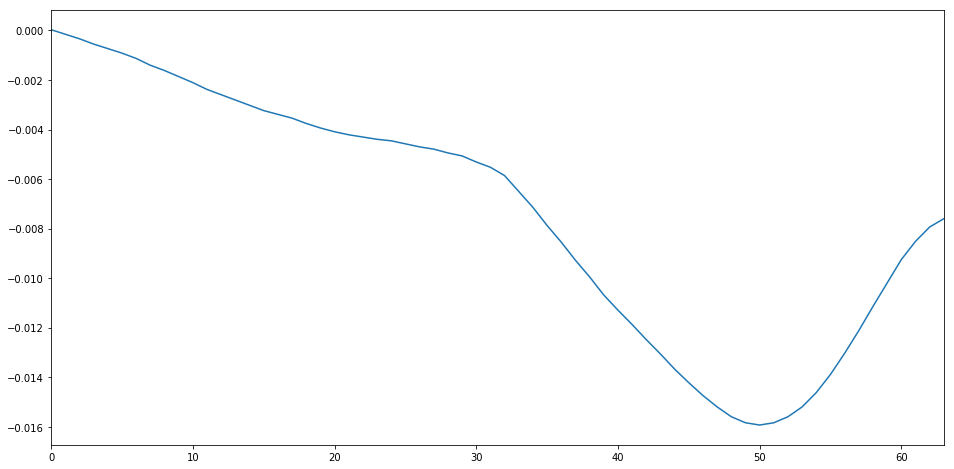

In [250]:
pd.Series(X_tr_f[0]).plot.line(figsize=(16, 8))

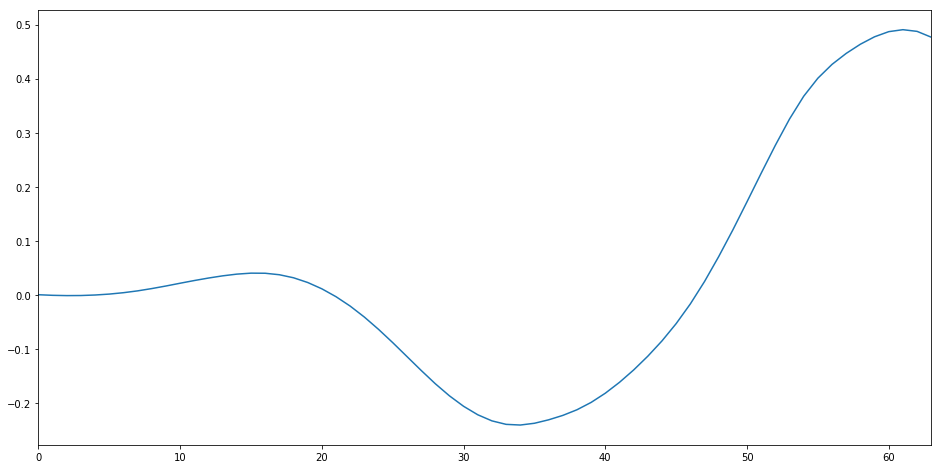

In [251]:
pd.Series(y_tr_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

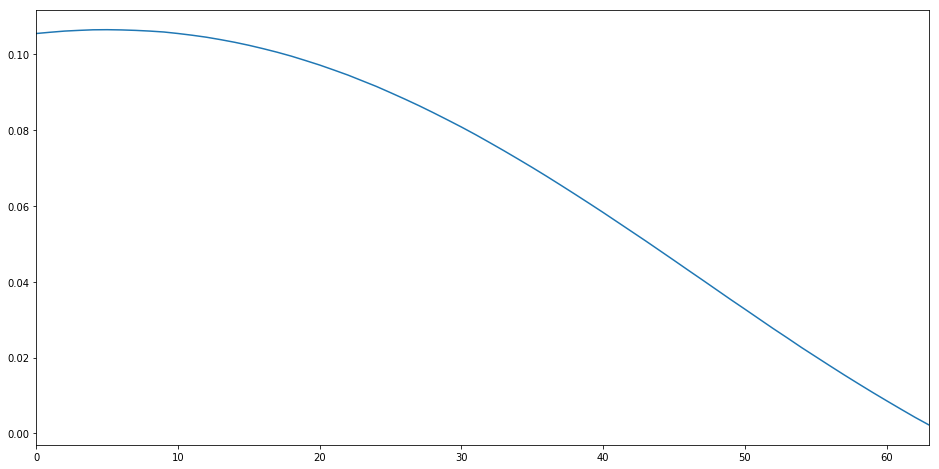

In [252]:
pd.Series(X_te_f[0]).plot.line(figsize=(16, 8))

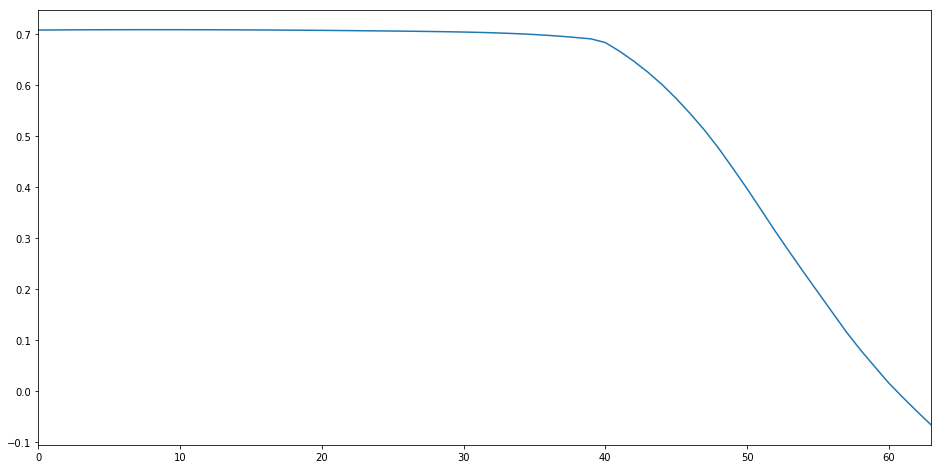

In [253]:
pd.Series(y_te_f[:N_WINDOW_POINTS]).plot.line(figsize=(16, 8))

In [254]:
n_features = 1

In [255]:
(X_tr_f[0], y_tr_f[0])

(array([ 3.05185094e-05, -1.52592547e-04, -3.35703604e-04, -5.49333170e-04,
        -7.32444227e-04, -9.15555283e-04, -1.12918485e-03, -1.40385143e-03,
        -1.61748100e-03, -1.86162908e-03, -2.10577715e-03, -2.38044374e-03,
        -2.59407330e-03, -2.80770287e-03, -3.02133244e-03, -3.23496200e-03,
        -3.38755455e-03, -3.54014710e-03, -3.75377666e-03, -3.93688772e-03,
        -4.08948027e-03, -4.21155430e-03, -4.30310983e-03, -4.39466536e-03,
        -4.45570238e-03, -4.57777642e-03, -4.69985045e-03, -4.79140598e-03,
        -4.94399853e-03, -5.06607257e-03, -5.31022064e-03, -5.52385021e-03,
        -5.85955381e-03, -6.50044251e-03, -7.14133121e-03, -7.87377544e-03,
        -8.54518265e-03, -9.27762687e-03, -9.94903408e-03, -1.06814783e-02,
        -1.12918485e-02, -1.18717002e-02, -1.24820704e-02, -1.30619220e-02,
        -1.36722922e-02, -1.42216254e-02, -1.47404401e-02, -1.51982177e-02,
        -1.55949583e-02, -1.58391073e-02, -1.59306619e-02, -1.58391073e-02,
        -1.5

In [256]:
X_tr_s = X_tr_f.reshape(X_tr_f.shape[0], X_tr_f.shape[1], 1)
X_tr_s[0][:5]

array([[ 3.0518509e-05],
       [-1.5259255e-04],
       [-3.3570360e-04],
       [-5.4933317e-04],
       [-7.3244423e-04]], dtype=float32)

In [257]:
y_tr_s = y_tr_f

In [258]:
X_te_s = X_te_f.reshape(X_te_f.shape[0], X_te_f.shape[1], 1)
X_te_s[0][:5]

array([[0.105533  ],
       [0.10586871],
       [0.1061739 ],
       [0.10635701],
       [0.1065096 ]], dtype=float32)

In [259]:
y_te_s = y_te_f

In [260]:
def add_stats(row):
    stats = [
        np.abs(row[-1]),
        -np.abs(row[-1]),
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
    ]

    return np.array([(list(x) + list(stats)) for x in row])

In [261]:
# %%time
# X_tr_s = np.array([add_stats(row) for row in X_tr_s])
# print(X_tr_s[0][0], X_tr_s[0][1])

In [262]:
# %%time
# X_te_s = np.array([add_stats(row) for row in X_te_s])
# print(X_te_s[0][0], X_te_s[0][1])

In [263]:
N_REPEAT = 4
N_REPEAT

4

In [264]:
X_tr_s[0][0]

array([3.051851e-05], dtype=float32)

In [265]:
# X_tr_s = np.repeat(X_tr_s, N_REPEAT, axis=0)
# X_tr_s[0][0], X_tr_s[1][0]

In [266]:
# y_tr_s = np.repeat(y_tr_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

In [267]:
# X_te_s = np.repeat(X_te_s, N_REPEAT, axis=0)
# X_te_s[0][0], X_te_s[1][0]

In [268]:
# y_te_s = np.repeat(y_te_s, N_REPEAT, axis=0)
# y_tr_s[0], y_tr_s[1]

## Finished data processing!

## Moving on to training NN

In [72]:
import numpy as np

In [73]:
# num_steps=100, 24 hidden states

In [74]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

Using TensorFlow backend.


In [75]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((44000, 64, 1), (44000,), (44000, 64, 1), (44000,))

In [76]:
y_tr_s

array([-5.4933317e-04, -6.4088870e-04, -5.4933317e-04, ...,
       -3.4980315e-01, -4.8310801e-01, -5.6160164e-01], dtype=float32)

In [77]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [78]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200, batch_size=1):
        self.model = model
        self.I = I
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        I = self.I
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(I))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = self.I
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I], batch_size=batch_size))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        # zeros = pd.Series(np.zeros(I))
        # zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(I, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [83]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    GRU_L = CuDNNGRU
    
    gru_1_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
        return_sequences=True,
    )(input_L)

    gru_2_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
    #     return_sequences=True,
    )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    # )(gru_1_l)
    )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params, verbose_fit=0):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(10 * (y_pred - y_true)), axis=-1)

    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.8
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    test_model_cb = TestModel(model, I=min(params['n_samples'], 2000), batch_size=params['batch_size'])

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
#         X_tr_s[:40],
#         y_tr_s[:40],
        batch_size=params['batch_size'],
        shuffle=False,
    #     epochs=400,
#         epochs=100,
        epochs=params['epochs'],
        verbose=verbose_fit,
#         validation_data=(X_te_s[:1000], y_te_s[:1000]),
        # validation_data=(X_te_s[:200], y_te_s[:200]),
        # callbacks=[es_cb, test_model_cb, tensorboard_cb],
        callbacks=[es_cb, test_model_cb, lrate],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

In [81]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()





  0%|          | 0/6 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 200, 'lr': 0.003, 'n_samples': 4000, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


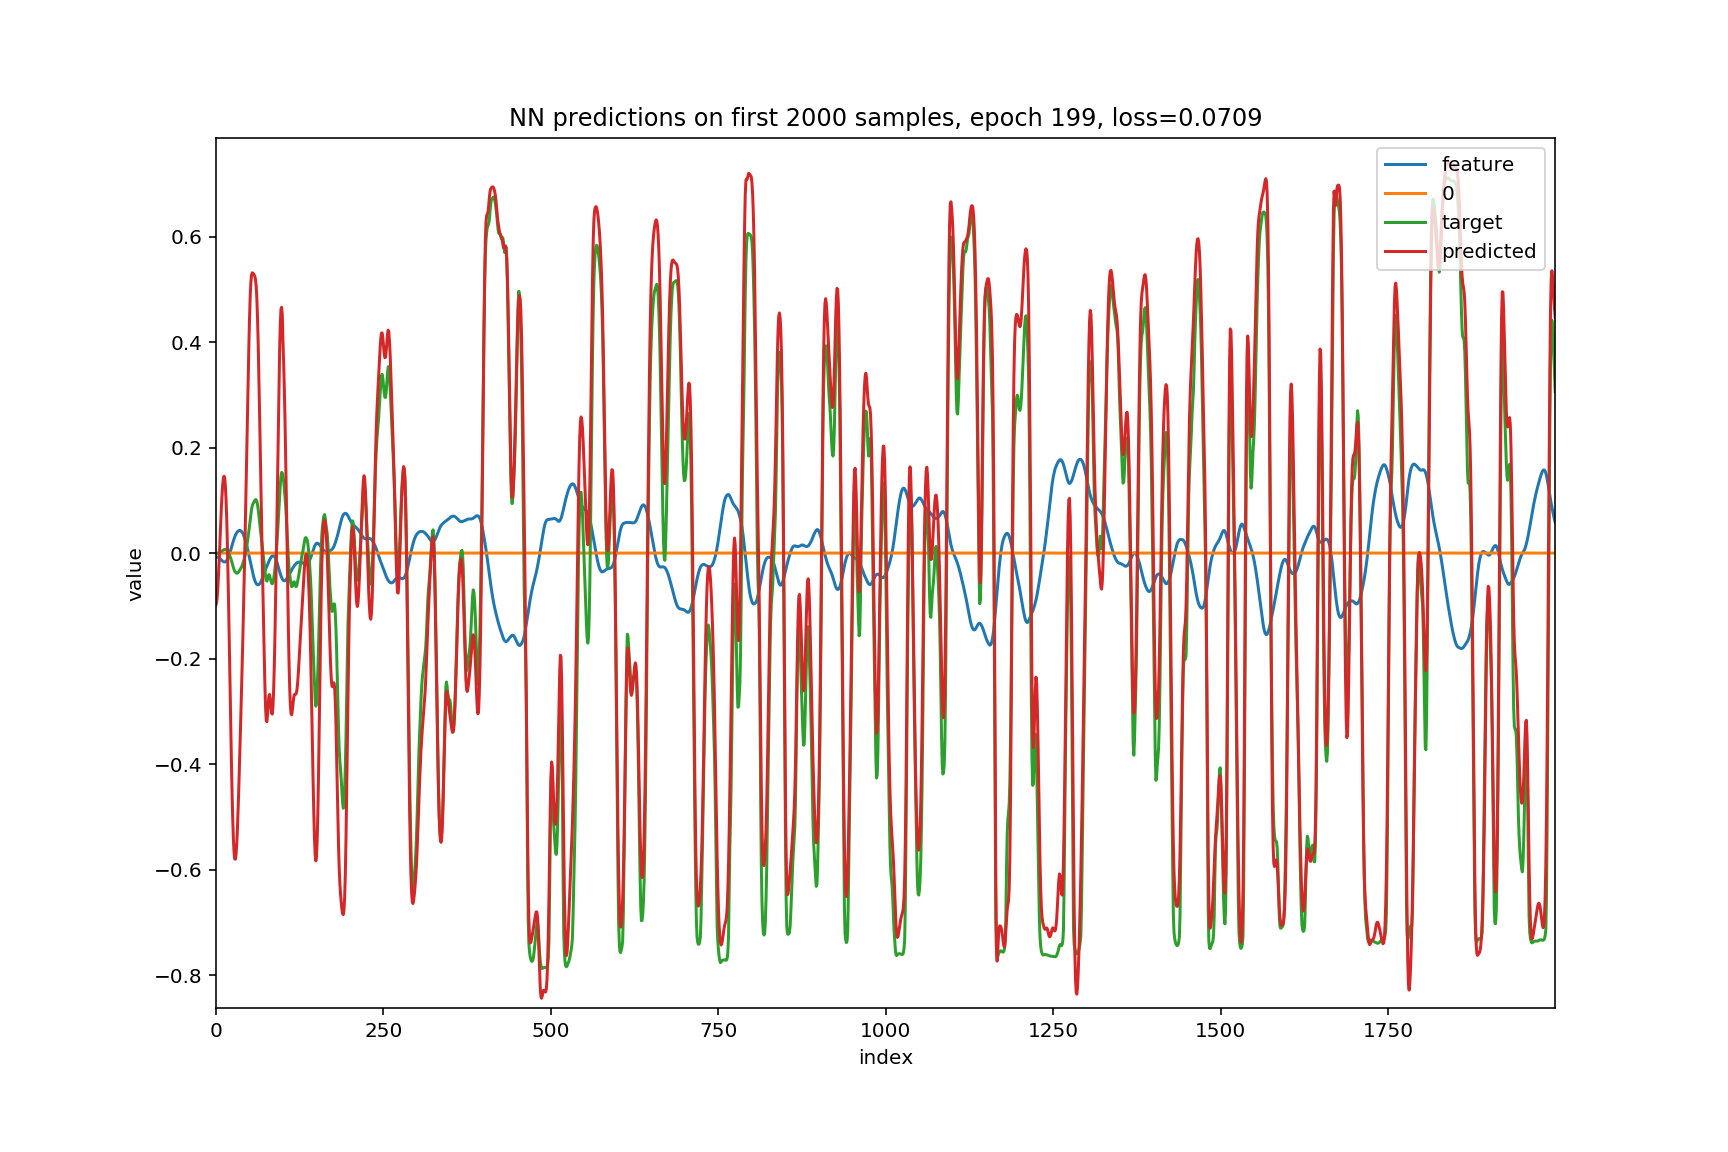





 17%|█▋        | 1/6 [01:31<07:35, 91.03s/it]

{'batch_size': 100, 'epochs': 200, 'lr': 0.003, 'n_samples': 4000, 'n_units': 32, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


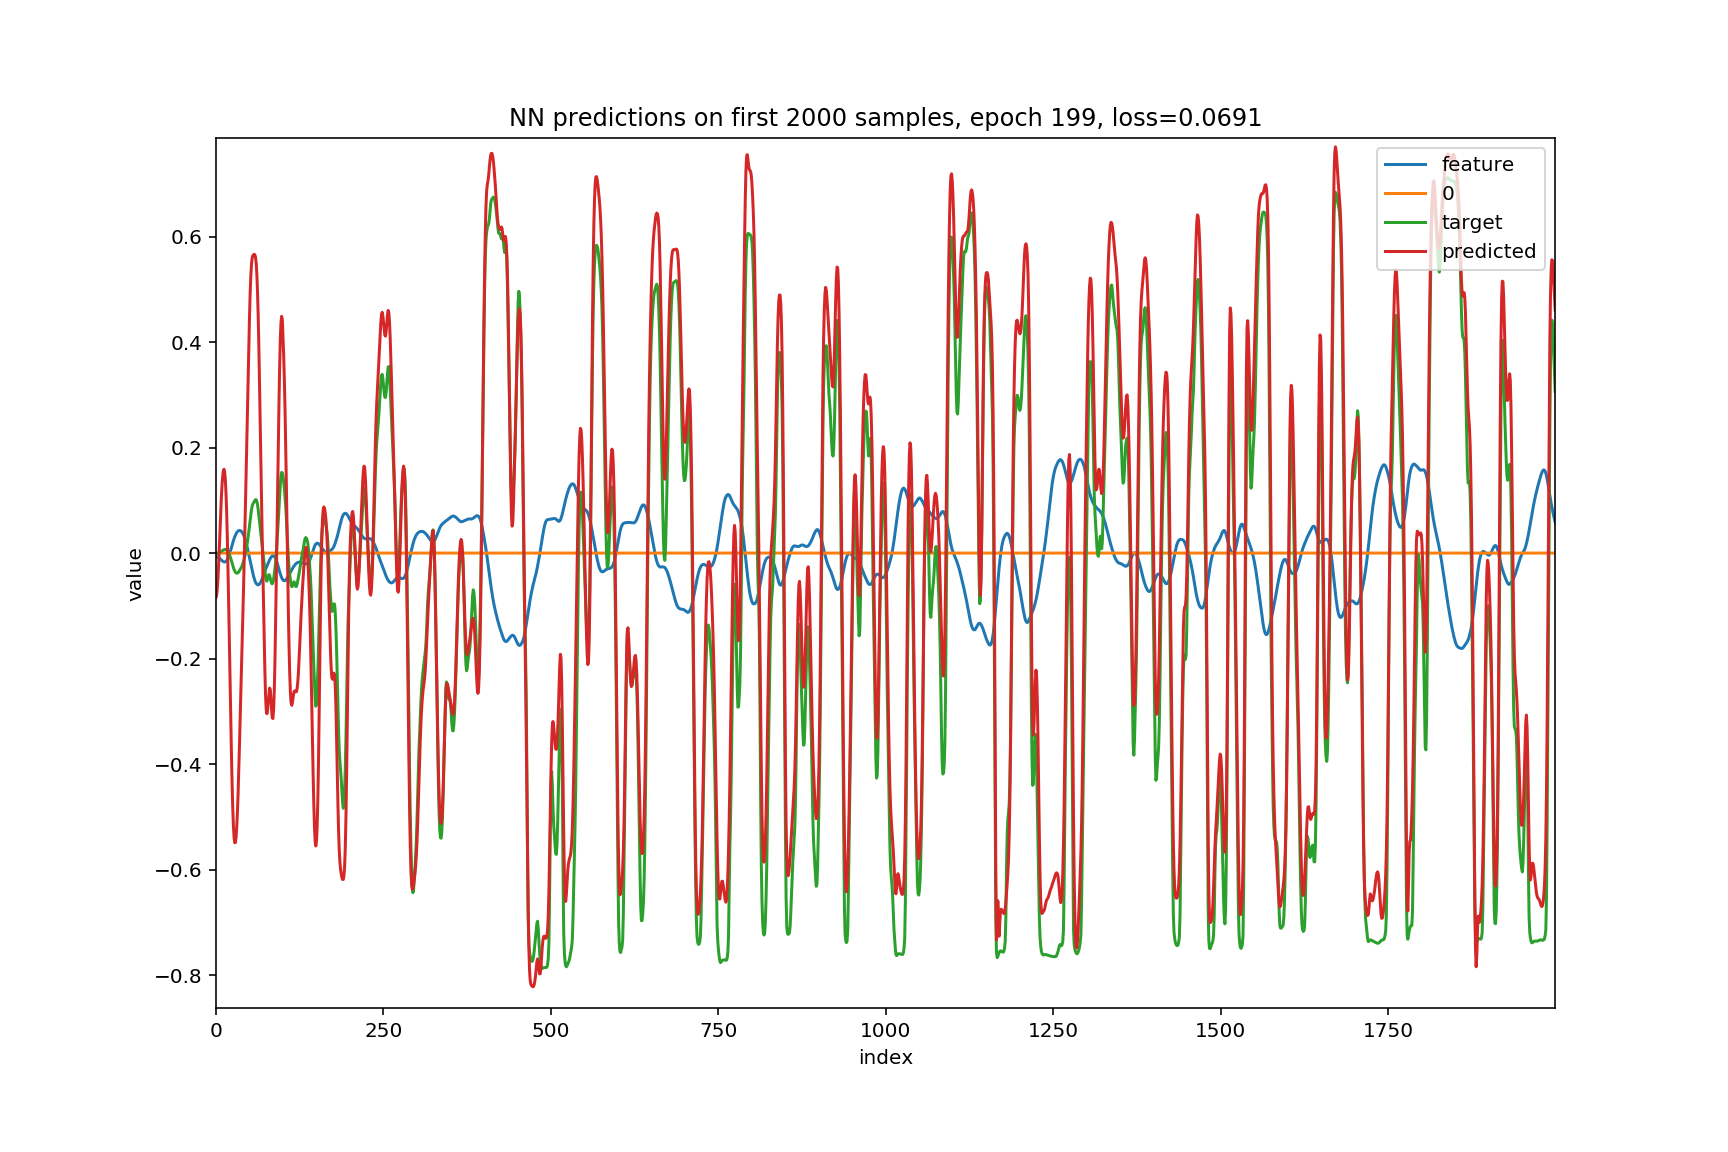





 33%|███▎      | 2/6 [03:01<06:03, 90.96s/it]

{'batch_size': 100, 'epochs': 200, 'lr': 0.003, 'n_samples': 4000, 'n_units': 64, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


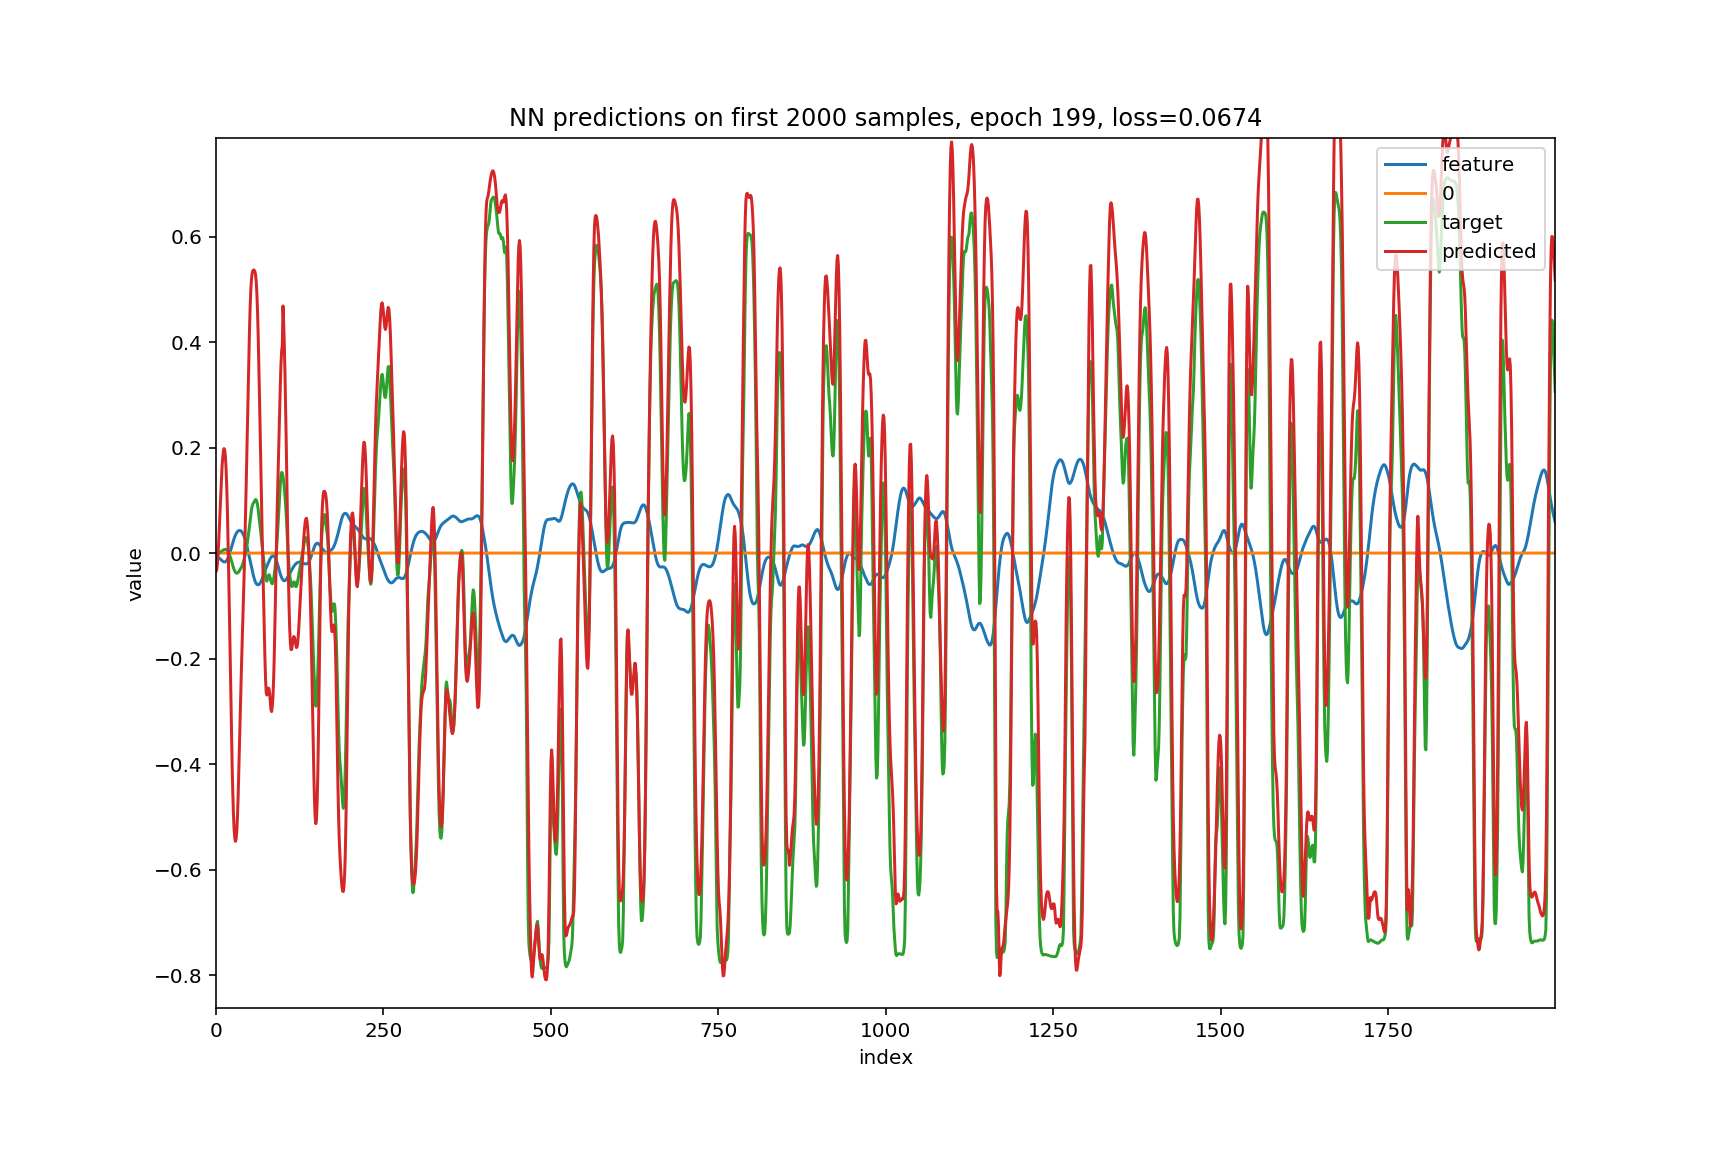





 50%|█████     | 3/6 [04:35<04:35, 91.77s/it]

{'batch_size': 100, 'epochs': 200, 'lr': 0.006, 'n_samples': 4000, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


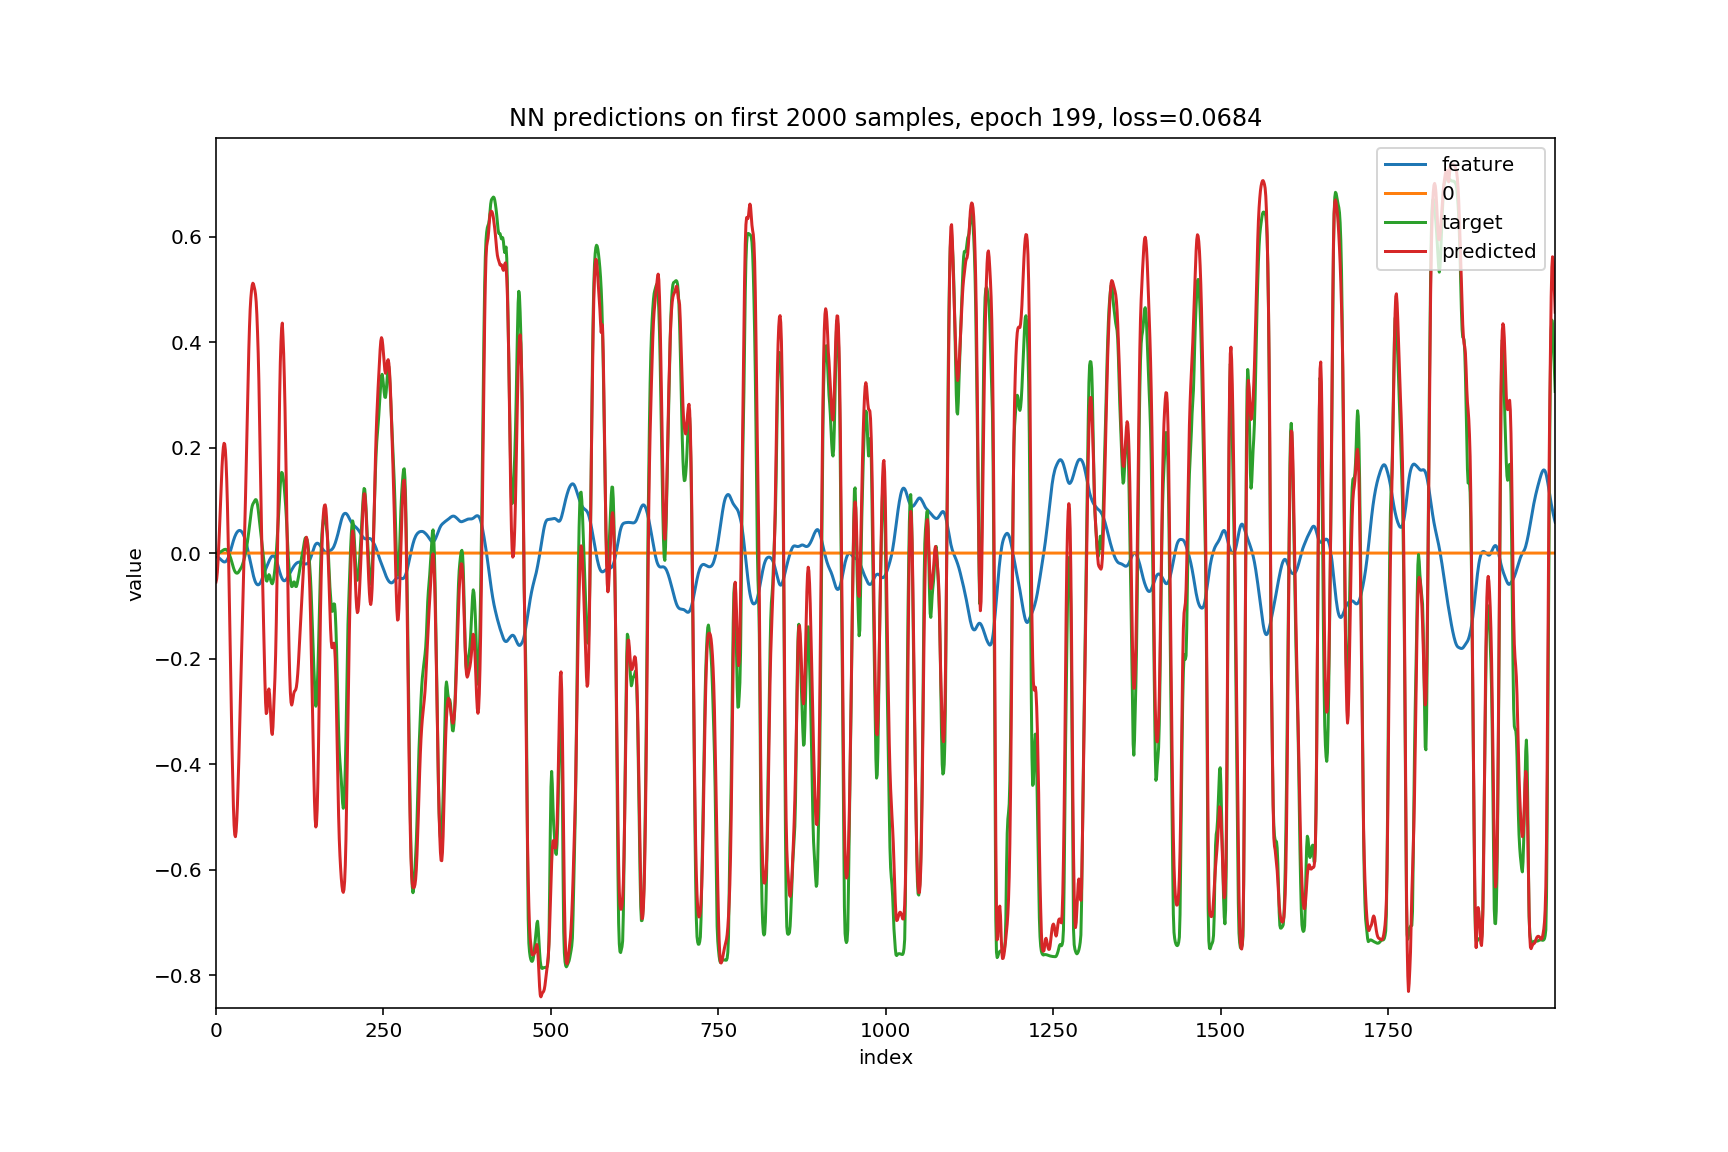





 67%|██████▋   | 4/6 [06:06<03:02, 91.43s/it]

{'batch_size': 100, 'epochs': 200, 'lr': 0.006, 'n_samples': 4000, 'n_units': 32, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


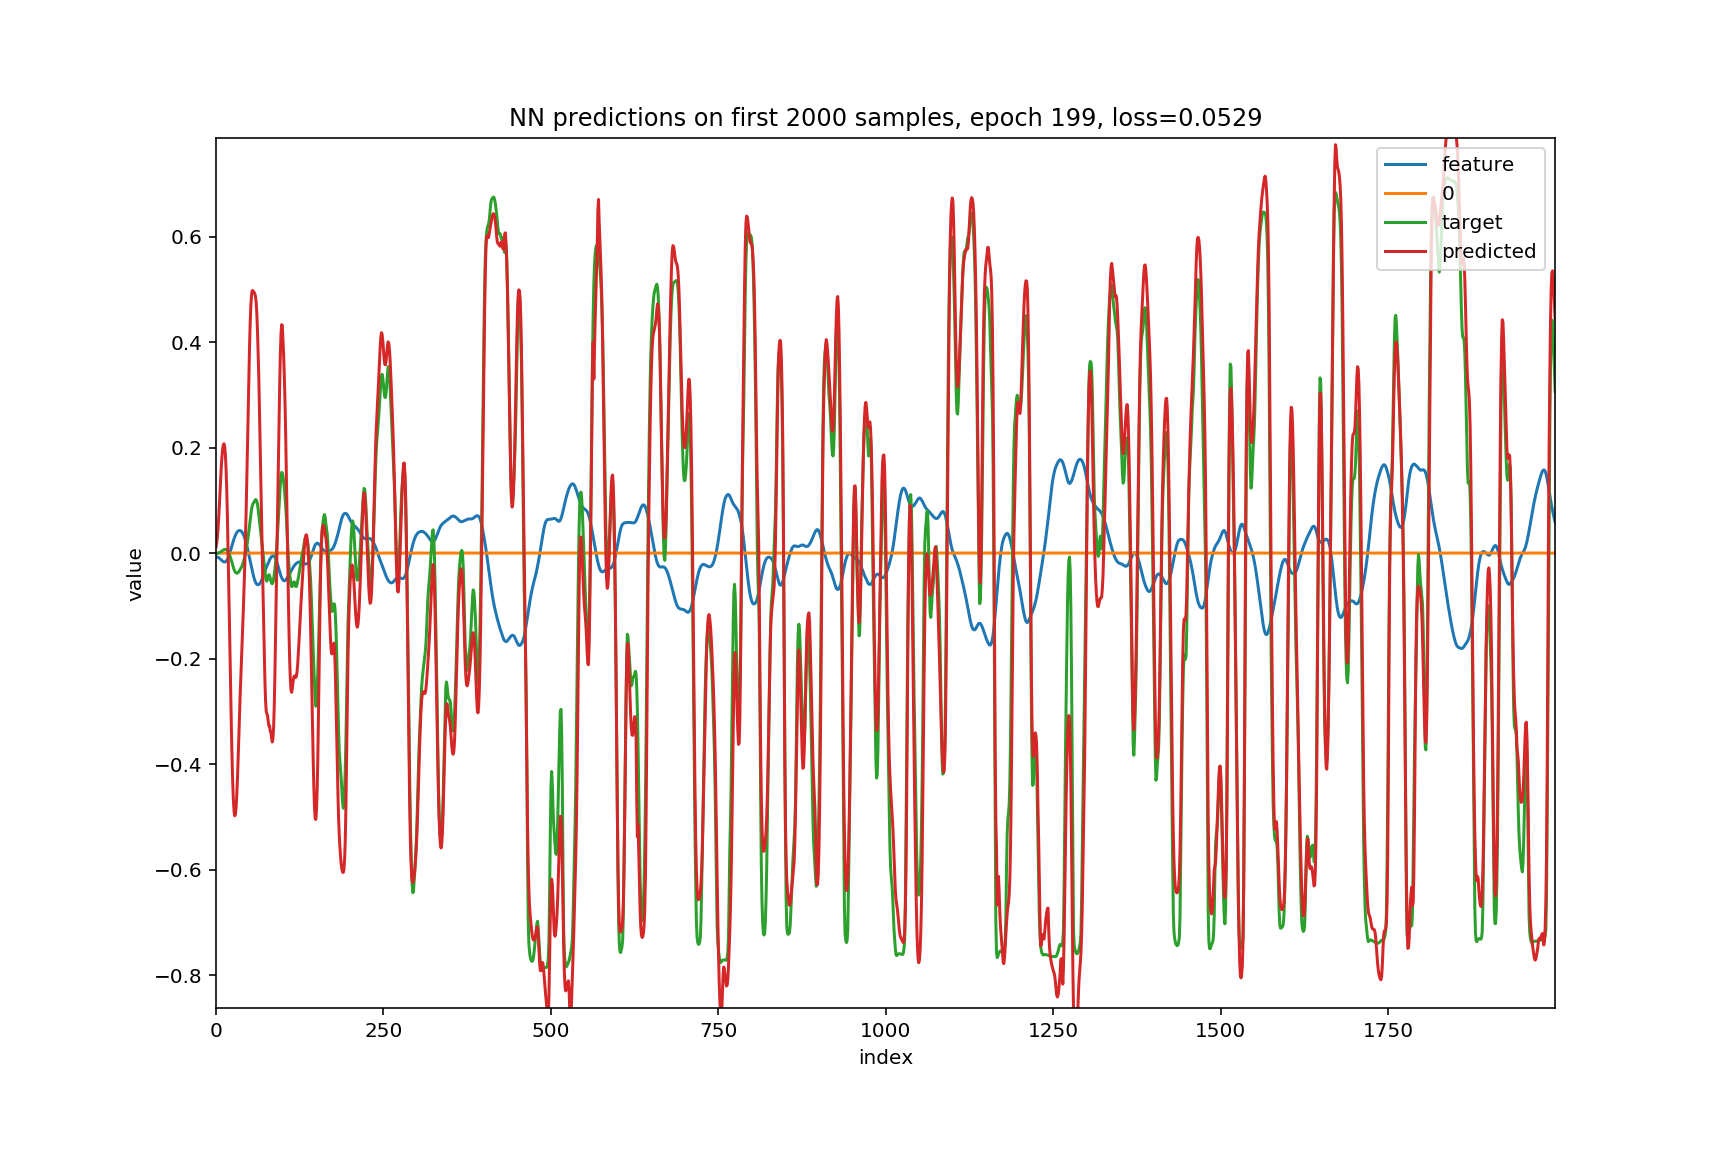





 83%|████████▎ | 5/6 [07:35<01:30, 90.96s/it]

{'batch_size': 100, 'epochs': 200, 'lr': 0.006, 'n_samples': 4000, 'n_units': 64, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


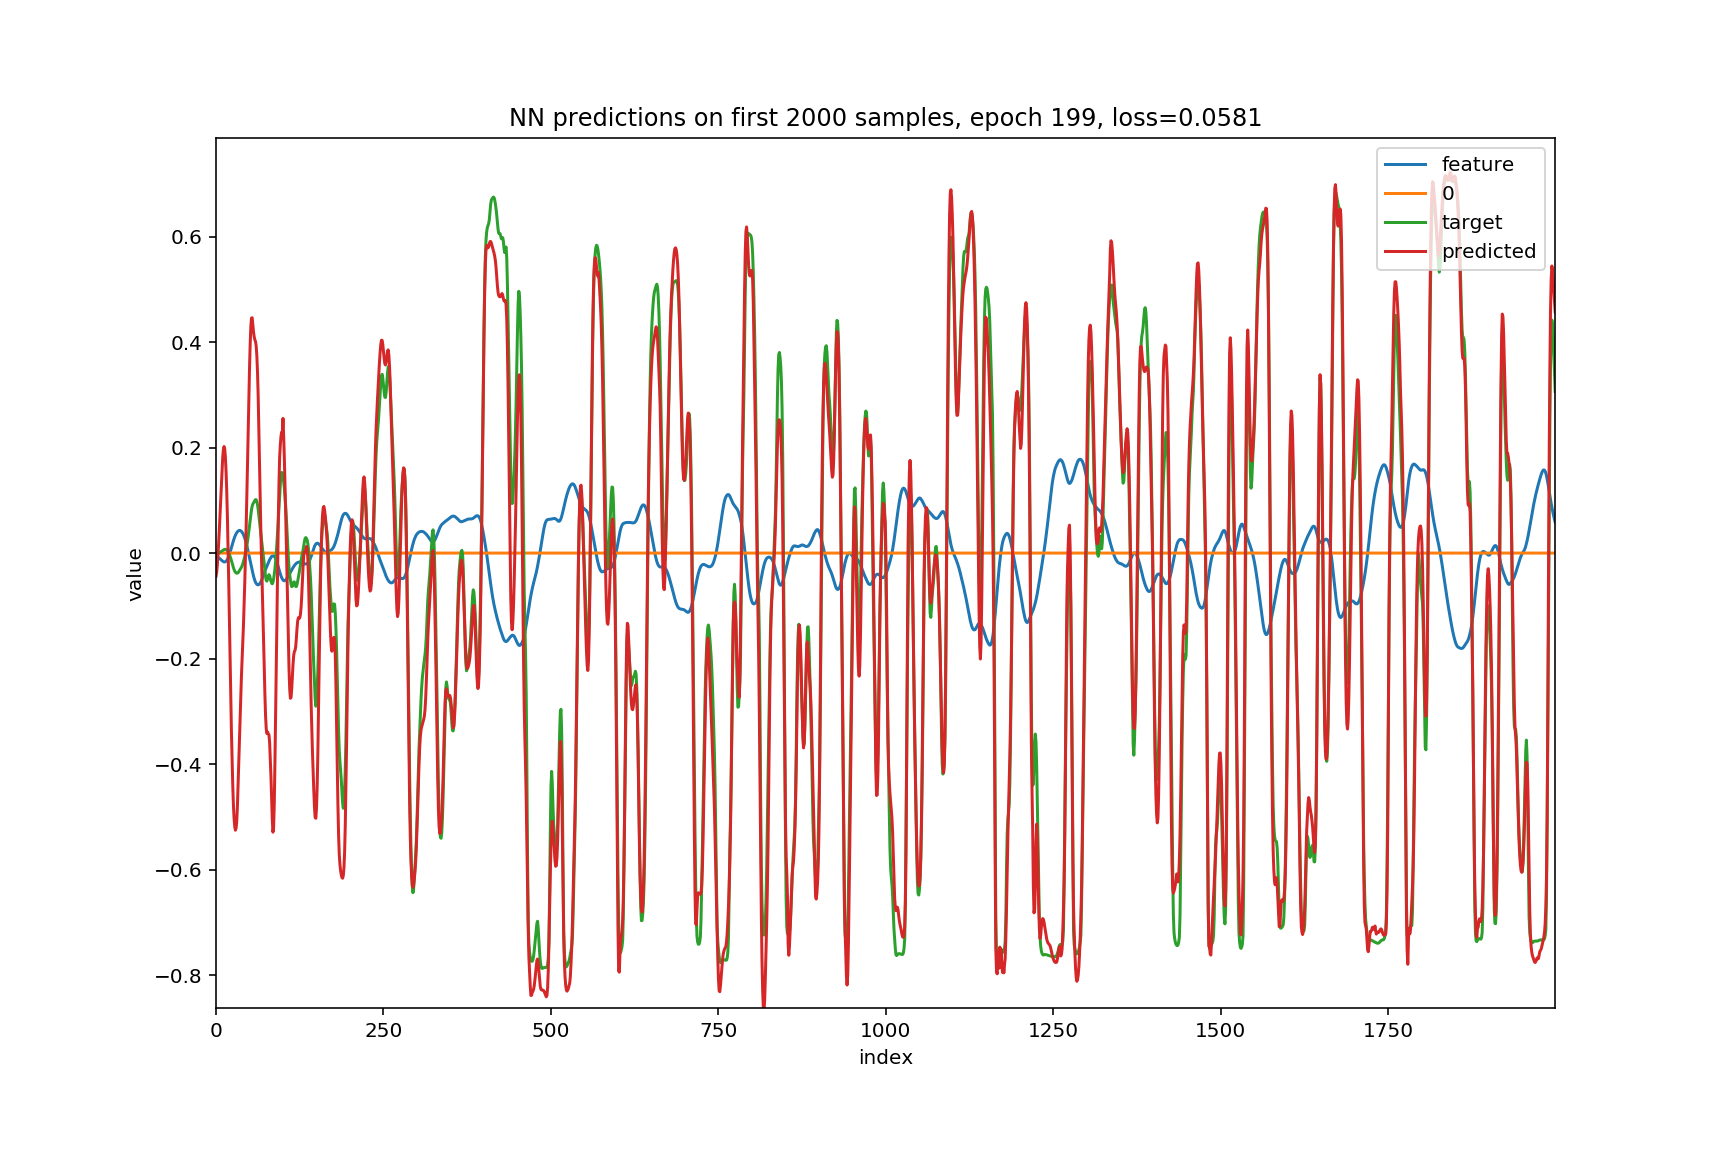





100%|██████████| 6/6 [09:08<00:00, 91.49s/it]

In [87]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.003, 0.006],
     'n_samples': [4000],
     'n_units': [16, 32, 64],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [200],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.006,
# 'n_samples': 500,
# 'n_units': 12,
# 'batch_size': 100,
# 'epochs': 300,

# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p)

globals().update(locals())

In [88]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


round_epochs      loss        lr  batch_size  epochs     lr  n_samples  \
4           200  0.052923  0.001966         100     200  0.006       4000   
5           200  0.058072  0.001966         100     200  0.006       4000   
2           200  0.067394  0.000983         100     200  0.003       4000   
3           200  0.068377  0.001966         100     200  0.006       4000   
1           200  0.069117  0.000983         100     200  0.003       4000   
0           200  0.070936  0.000983         100     200  0.003       4000   

   n_units                        optimizer  
4       32  <class 'keras.optimizers.Adam'>  
5       64  <class 'keras.optimizers.Adam'>  
2       64  <class 'keras.optimizers.Adam'>  
3       16  <class 'keras.optimizers.Adam'>  
1       32  <class 'keras.optimizers.Adam'>  
0       16  <class 'keras.optimizers.Adam'>

In [91]:
best_params = r.data.loc[4]
best_params

round_epochs                                200
loss                                  0.0529229
lr                                   0.00196608
batch_size                                  100
epochs                                      200
lr                                        0.006
n_samples                                  4000
n_units                                      32
optimizer       <class 'keras.optimizers.Adam'>
Name: 4, dtype: object

In [ ]:
type(best_params)

{'lr': 0.004, 'n_samples': 132000, 'n_units': 20, 'batch_size': 500, 'epochs': 100, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


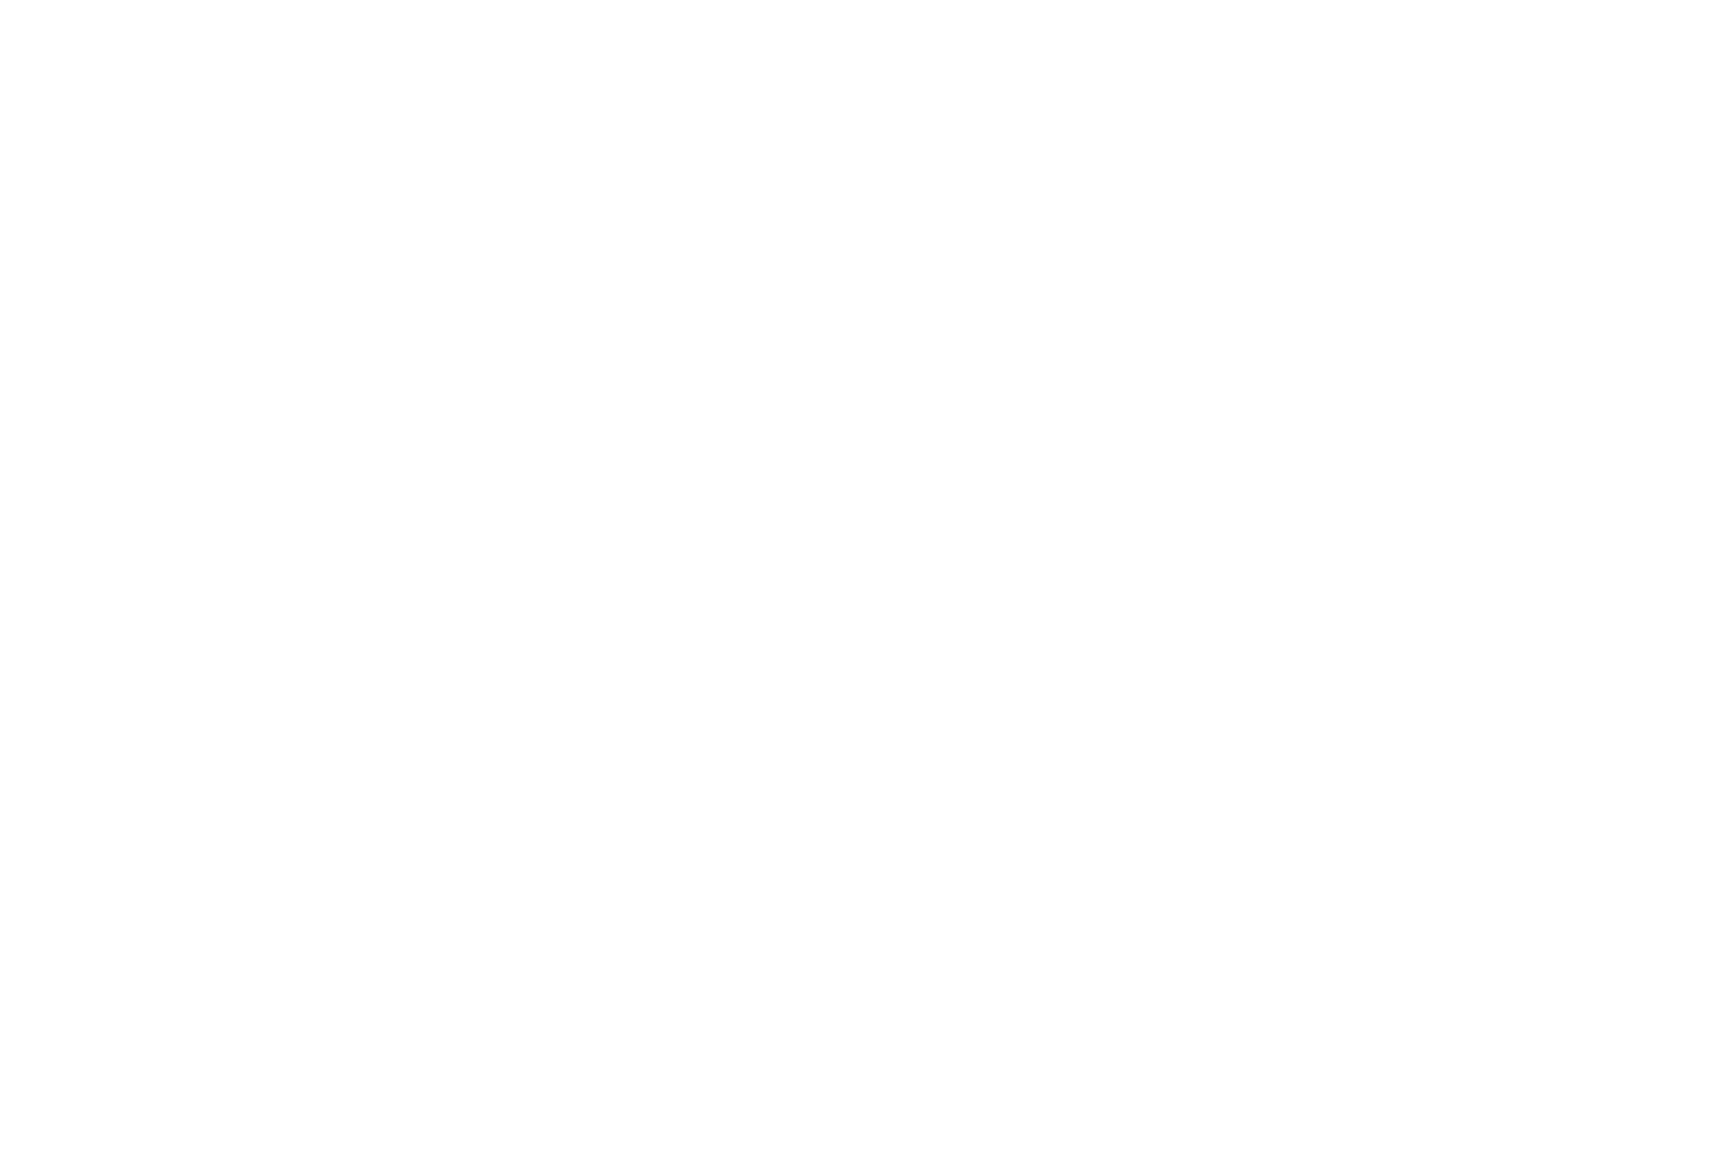

Epoch 1/100
132000/132000 [==============================] - 4s 32us/step - loss: 0.3395
Epoch 2/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.2695
Epoch 3/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.1267
Epoch 4/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0791
Epoch 5/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0726
Epoch 6/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0699
Epoch 7/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0647
Epoch 8/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0624
Epoch 9/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0607
Epoch 10/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0593
Epoch 11/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0588
Epoch 12/100
132000

132000/132000 [==============================] - 3s 22us/step - loss: 0.0462
Epoch 93/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0461
Epoch 94/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0460
Epoch 95/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0459
Epoch 96/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0459
Epoch 97/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0457
Epoch 98/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0455
Epoch 99/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0458
Epoch 100/100
132000/132000 [==============================] - 3s 22us/step - loss: 0.0457


<IPython.core.display.Javascript object>


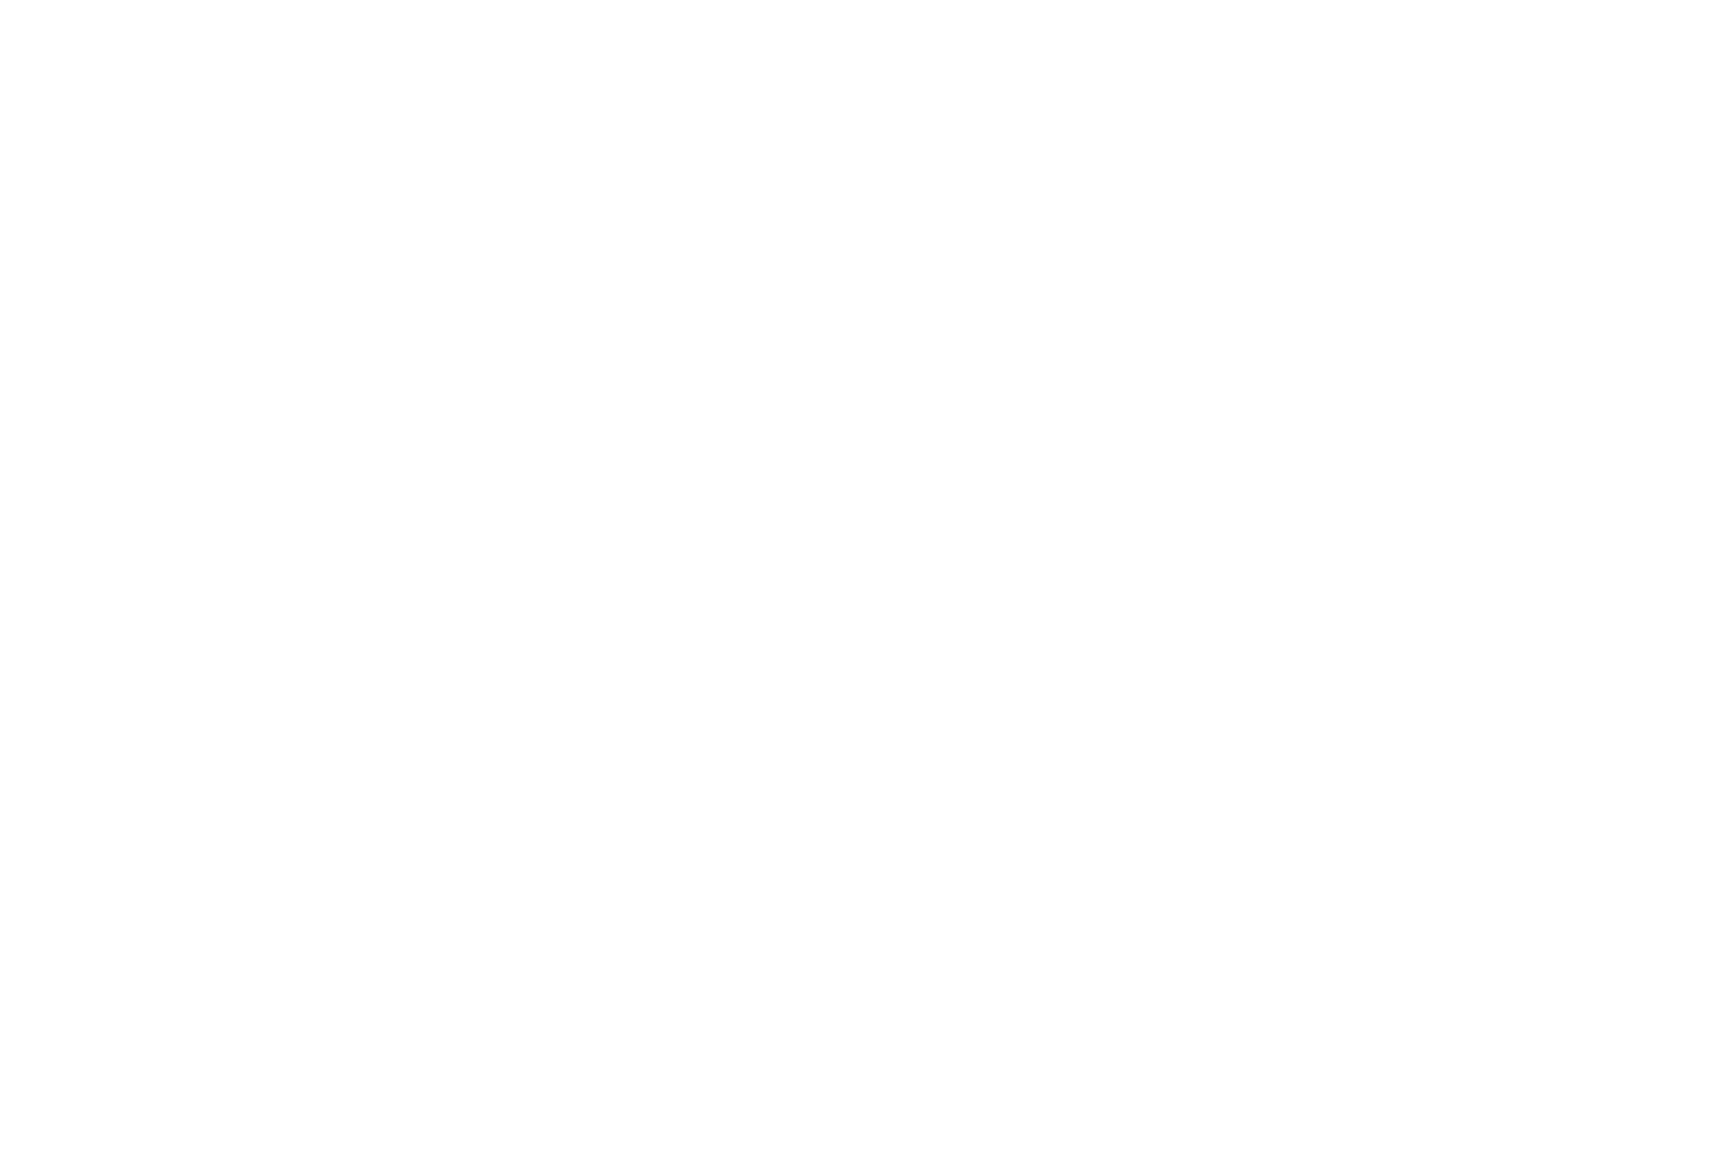

In [269]:
%matplotlib notebook

best_params = {
    'lr': 0.004,
    'n_samples': 44000 * 3,
    'n_units': 20,
    'batch_size': 500,
    'epochs': 100,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
)

globals().update(locals())

In [93]:
MAGIC_OFFSET = 300

In [94]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-1.0542217 , -2.0400574 ,  0.16562434, -0.40750715,  0.00946442,
        -0.79306406, -0.64443284, -0.28367478, -0.25780112, -0.25150317,
        -0.00590053, -1.5190881 , -0.16542548, -0.2883568 , -0.25472176,
        -0.04175141,  0.49945095, -0.84092546, -0.24202286,  0.3609125 ,
        -0.5653433 , -0.9720504 ,  0.16121832, -0.02230433, -0.31673566,
        -0.09012976, -0.09157756,  0.92050916, -0.749299  , -0.04214865,
        -0.30917585, -0.8132706 , -0.58028126, -0.49317527,  0.5145796 ,
         0.40117255, -0.17957827,  0.28148535,  1.0253348 ,  0.06600922,
        -0.19151488,  0.5204258 ,  0.35874048, -0.3101858 , -0.05816564,
        -0.25676444,  0.24082208,  0.18718453,  0.28544664, -0.02371157,
         0.9487932 ,  0.1896305 ,  0.27959275, -0.11124075,  0.30538777,
         0.03216783,  0.3352971 ,  0.7558699 ,  0.5857257 ,  0.15626669,
         0.00836458,  0.44791332,  0.6321611 ,  0.24387425,  1.7070391 ,
         0.10131935,  0.23255527,  0.01118938, 

In [158]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (500, 64, 1)              0         
_________________________________________________________________
cu_dnngru_13 (CuDNNGRU)      (500, 64, 20)             1380      
_________________________________________________________________
cu_dnngru_14 (CuDNNGRU)      (500, 20)                 2520      
_________________________________________________________________
dense_7 (Dense)              (500, 1)                  21        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


In [164]:
# model.save('saved_models/02_peak_comp_60_samples_180_params.h5')

In [270]:
score = model.evaluate(X_te_s[:260000], y_te_s[:260000], verbose=0, batch_size=best_params['batch_size'])
score

0.15225049171310204

In [160]:
0.029539166018366814
0.03891629166901111
0.04739629477262497

0.04739629477262497

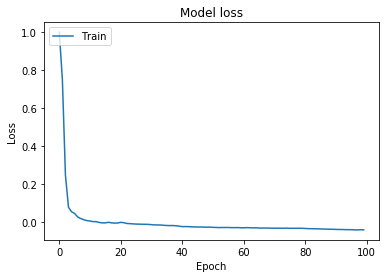

In [271]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [107]:
len(X_te_f)

44000

In [108]:
predict(model, X_te_s[:100], batch_size=best_params['batch_size'])

array([ 0.42074916,  0.4188126 ,  0.41598648,  0.41277906,  0.40851912,
        0.4037629 ,  0.3983864 ,  0.3926526 ,  0.38597345,  0.37842116,
        0.3705096 ,  0.361632  ,  0.35192588,  0.34092385,  0.32864466,
        0.31568202,  0.30268106,  0.29069376,  0.28162712,  0.27519011,
        0.27254406,  0.27350447,  0.27352455,  0.26886126,  0.26181582,
        0.25466263,  0.24930623,  0.24505895,  0.24231344,  0.23949894,
        0.23742515,  0.23477152,  0.2312414 ,  0.22749475,  0.22364408,
        0.21994355,  0.2163364 ,  0.21182036,  0.2059817 ,  0.19874221,
        0.19102111,  0.18264833,  0.17472953,  0.16714606,  0.15959707,
        0.15110868,  0.14199403,  0.13170949,  0.12126684,  0.11032544,
        0.10013771,  0.09057215,  0.08067086,  0.0706026 ,  0.06075238,
        0.05121189,  0.04213148,  0.03372679,  0.0260295 ,  0.01935473,
        0.01373389,  0.00891228,  0.00369877, -0.00247651, -0.00914977,
       -0.01529282, -0.01987837, -0.02368823, -0.02737702, -0.03

In [109]:
print(X_tr_s[0][-1])

[-0.00759911]


0   -0.423522
1   -0.355096
2   -0.280052
3   -0.200533
4   -0.116192
dtype: float32


Text(0,0.5,'value')

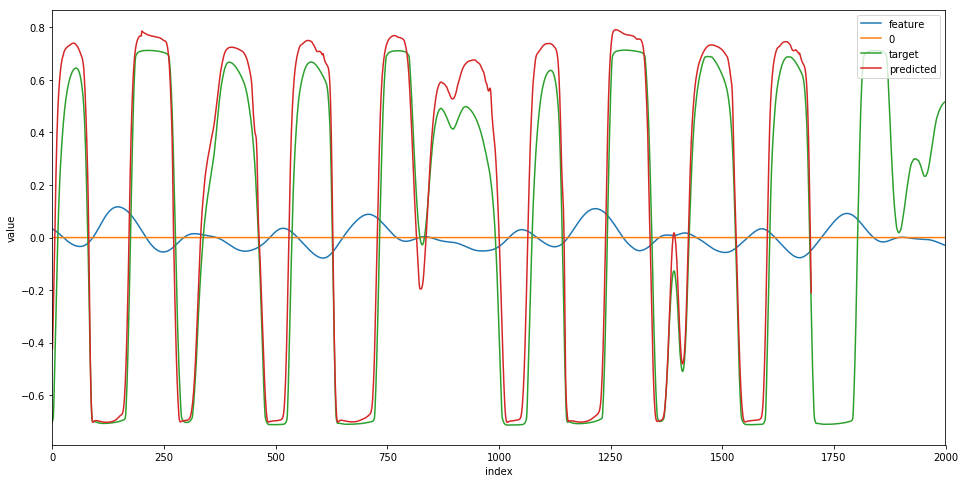

In [274]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 2000
OFFSET = int(MAGIC_OFFSET) + 0

X_to_test = X_te_s
y_to_test = y_te_s

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_to_test[:(I + OFFSET)]))))[OFFSET:])

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[:(I + OFFSET)], batch_size=best_params['batch_size'])[OFFSET:])
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')


## Time to evaluate performance

In [275]:
predictions = predict(model, X_tr_s[:(44000 * 12)], batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

528000/528000 [==============================] - 3s 6us/step


(528000,
 array([-0.07577601, -0.12852612, -0.14336358, -0.11273335, -0.03324272,
         0.0884965 ,  0.23204064,  0.36834806,  0.47442627,  0.5431318 ],
       dtype=float32),
 0.8639639,
 -0.84850127)

In [276]:
predictions_n = np.clip((predictions / 0.89) * 0.8, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(528000, array([-2231.8674, -3785.542 , -4222.5566, -3320.3896,  -979.1141,
         2606.5303,  6834.406 , 10849.134 , 13973.506 , 15997.124 ],
       dtype=float32), 25446.746, -24991.318)

In [277]:
wavfile.write('output/pred_out_gr_jump_head_hg_v1.wav', source_fs, predictions)

In [278]:
len(predictions)

528000